# 02 - Synthetic Validation (Registro de 3 imágenes sinteticas)

**Introducción:**
En este notebook crearemos un conjunto de imágenes y definiremos las funciones que posteriormente estarán ubicadas en los distintos módulos de la estructura del proyecto.
A continuación, aplicaremos la lógica de dichas funciones, en un orden establecido, sobre las imágenes sintéticas para realizar un análisis de los resultados obtenidos.

**Objetivo:**
Evaluar y cuantificar la precisión de un pipeline de registro **para dos imagenes** (detección, descripción, emparejamiento y estimación con RANSAC) utilizando transformaciones sintéticas con ground truth.
- Estructura del notebook:
- Generar una imagen base sintética.
- Aplicar transformaciones conocidas (ground truth).
- Detectar y describir características (SIFT preferido, ORB como alternativa).
- Emparejar con FLANN y aplicar la prueba de razón de Lowe.
- Estimar la transformación con RANSAC y descomponerla (escala, rotación y traslación).
- Calcular métricas y guardar resultados y figuras.


In [1]:
# Importar librerías
import numpy as np
import cv2
import math
from typing import Tuple, List, Dict, Optional, Any
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

# Configuración inicial
np.random.seed(0)
plt.rcParams['figure.figsize'] = (10,6)


In [2]:
# Carpeta de salida para resultados
OUTPUT_DIR = '../data/synthetic'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Transformaciones sintéticas pre-establecidas a utilizar (ground truth)
TRANSFORMS = [
    {'id': 0, 'angle': 0.0, 'scale': 1.0, 'tx': 0.0, 'ty': 0.0},
    {'id': 1, 'angle': 10.0, 'scale': 1.02, 'tx': 15.0, 'ty': -8.0},
    {'id': 2, 'angle': -12.5, 'scale': 0.95, 'tx': -20.0, 'ty': 30.0},
    {'id': 3, 'angle': 25.0, 'scale': 1.15, 'tx': 40.0, 'ty': -20.0},
]


In [3]:
def apply_transform(
        img: np.ndarray,
        angle_deg: float,
        scale: float,
        tx: float,
        ty: float
) -> Tuple[np.ndarray, np.ndarray]:
    """Aplica una transformación afín (rotación, escala, traslación) a la imagen."""
    H, W = img.shape[:2]
    center = (W/2.0, H/2.0)
    M = cv2.getRotationMatrix2D(center, angle_deg, scale)
    M[0,2] += tx
    M[1,2] += ty
    transformed = cv2.warpAffine(img, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return transformed, M

In [4]:
# Convertir las transformaciones a matrices para comparación posterior
for transform in TRANSFORMS:
    # Generar la matriz de transformación usando los parámetros
    transformed, matrix = apply_transform(
        np.zeros((600, 800), dtype=np.uint8),  # dummy image for matrix calculation
        transform['angle'],
        transform['scale'],
        transform['tx'],
        transform['ty']
    )
    transform['matrix'] = matrix  # Guardar la matriz para comparación posterior

In [5]:
# Funciones: crear imagen base y aplicar transformaciones conocidas
def create_base_image(
        size: Tuple[int,int]=(800,600)
) -> np.ndarray:
    """Crea una imagen sintética con formas geométricas y texto para pruebas de registro."""
    W, H = size
    img = np.zeros((H, W), dtype=np.uint8)
    cv2.rectangle(img, (50,50), (250,200), 200, thickness=-1)
    cv2.circle(img, (500,150), 80, 255, thickness=-1)
    cv2.line(img, (300,400), (700,500), 150, thickness=10)
    cv2.putText(img, 'SINTETICA', (60,500), cv2.FONT_HERSHEY_SIMPLEX, 2.0, 180, 4, cv2.LINE_AA)
    # puntos aleatorios para enriquecer keypoints
    rng = np.random.default_rng(12345)
    for _ in range(300):
        x = rng.integers(0, W)
        y = rng.integers(0, H)
        img[y, x] = rng.integers(100, 256)
    return img



In [6]:
# Detección y descripción (se asume SIFT disponible)
def detect_and_describe(
        img: np.ndarray
) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
    """Detecta keypoints y calcula descriptores SIFT en la imagen dada."""
    sift = cv2.SIFT_create()
    kps, desc = sift.detectAndCompute(img, None)
    return kps, desc


In [7]:
# Emparejamiento (FLANN) y Lowe's ratio test
def match_descriptors(
        desc1: np.ndarray,
        desc2: np.ndarray,
        ratio: float = 0.75
) -> List[cv2.DMatch]:
    """Empareja descriptores entre dos imágenes usando FLANN y aplica el ratio test de Lowe."""
    if desc1 is None or desc2 is None:
        return []
    # FLANN parameters for SIFT (float descriptors)
    index_params = dict(algorithm=1, trees=5)  # KDTree
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    knn_matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in knn_matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return sorted(good, key=lambda x: x.distance)


In [8]:
# Estimación de una transformación afín con RANSAC y descomposición
def estimate_affine_from_matches(
        kps1: List[cv2.KeyPoint],
        kps2: List[cv2.KeyPoint],
        matches: List[cv2.DMatch],
        ransac_thresh: float = 3.0
) -> Tuple[Optional[np.ndarray], Optional[np.ndarray]]:
    """Estima una transformación afín entre dos conjuntos de keypoints usando RANSAC."""
    if len(matches) < 3:
        return None, None
    pts1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kps2[m.trainIdx].pt for m in matches])
    M, mask = cv2.estimateAffinePartial2D(pts1, pts2, method=cv2.RANSAC, ransacReprojThreshold=ransac_thresh)
    return M, mask

def decompose_affine(
        M: np.ndarray
) -> Optional[Dict[str, float]]:
    """Descompone una matriz de transformación afín en escala, ángulo y traslación."""
    if M is None:
        return None
    A = M[:, :2]
    tx, ty = M[:, 2]
    # Polar decomposition: A = R * S where R is rotation, S symmetric positive-definite
    try:
        U, s, Vt = np.linalg.svd(A)
        R = U @ Vt
        # scale aproximacion como media de los valores singulares
        scale = float(np.mean(s))
        angle_rad = math.atan2(R[1,0], R[0,0])
        angle_deg = math.degrees(angle_rad)
        return {'scale': scale, 'angle': angle_deg, 'tx': float(tx), 'ty': float(ty)}
    except Exception as e:
        print('Error decomposing affine:', e)
        return None


In [9]:
# Métricas de evaluación
def compute_errors(
        gt: Dict[str,float],
        est: Dict[str,float]
) -> Dict[str, Optional[float]]:
    """Calcula errores entre la transformación estimada y la ground truth."""
    out = {}
    for k in ['scale','angle','tx','ty']:
        if gt.get(k) is None or est.get(k) is None:
            out[k+'_err'] = None
        else:
            out[k+'_err'] = est[k] - gt[k]
    if out['tx_err'] is not None and out['ty_err'] is not None:
        out['rmse_trans'] = math.hypot(out['tx_err'], out['ty_err'])
    else:
        out['rmse_trans'] = None
    return out


In [10]:
# Funciones adicionales para métricas
def calculate_registration_error(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    Calcula el error de registro entre dos imágenes usando diferencia absoluta media.
    """
    diff = cv2.absdiff(img1, img2)
    return np.mean(diff)

def calculate_matrix_difference(H1: np.ndarray, H2: np.ndarray) -> float:
    """
    Calcula la diferencia entre dos matrices de transformación.
    Maneja tanto matrices afines (2x3) como homografías (3x3).
    """
    if H1 is None or H2 is None:
        return float('inf')
    
    # Convertir matriz afín a homografía si es necesario
    def to_homography(M):
        if M.shape[0] == 2:  # Si es matriz afín (2x3)
            H = np.eye(3, dtype=M.dtype)
            H[0:2, :] = M
            return H
        return M
    
    # Convertir ambas matrices a formato homografía
    H1_full = to_homography(H1)
    H2_full = to_homography(H2)
    
    # Normalizar las matrices
    H1_norm = H1_full / H1_full[2, 2]
    H2_norm = H2_full / H2_full[2, 2]
    
    # Calcular error Frobenius
    return np.linalg.norm(H1_norm - H2_norm)

In [11]:
# Visualización de matches y guardado de resultados
def draw_and_save_matches(
        img1: np.ndarray,
        kps1,
        img2: np.ndarray,
        kps2,
        matches,
        out_path: str,
        max_matches: int = 50
):
    """Dibuja los matches entre dos imágenes y guarda el resultado."""
    img1c = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2c = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    out_img = cv2.drawMatches(img1c, kps1, img2c, kps2, matches[:max_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # Convert BGR->RGB for matplotlib display when using plt.imshow
    out_img_rgb = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14,7))
    plt.imshow(out_img_rgb)
    plt.axis('off')
    plt.title(f'Matches (save: {out_path})')
    plt.show()
    cv2.imwrite(out_path, cv2.cvtColor(out_img_rgb, cv2.COLOR_RGB2BGR))


In [12]:
def apply_synthetic_transform(image: np.ndarray, transform: Dict) -> np.ndarray:
    """
    Aplica una transformación sintética a una imagen.
    
    Args:
        image: Imagen de entrada
        transform: Diccionario con la matriz de transformación y parámetros
        
    Returns:
        Imagen transformada
    """
    height, width = image.shape[:2]
    matrix = transform['matrix']
    
    # Aplicar la transformación
    transformed = cv2.warpPerspective(
        image,
        matrix,
        (width, height),
        flags=cv2.INTER_LINEAR
    )
    
    # Si hay parámetros adicionales de transformación
    if 'noise_level' in transform:
        # Agregar ruido gaussiano
        noise = np.random.normal(0, transform['noise_level'], transformed.shape)
        transformed = np.clip(transformed + noise, 0, 255).astype(np.uint8)
        
    if 'blur_kernel' in transform:
        # Aplicar desenfoque
        transformed = cv2.GaussianBlur(
            transformed, 
            (transform['blur_kernel'], transform['blur_kernel']),
            0
        )
        
    if 'brightness_factor' in transform:
        # Ajustar brillo
        transformed = cv2.convertScaleAbs(
            transformed, 
            alpha=transform['brightness_factor'],
            beta=0
        )
        
    return transformed

In [13]:
def visualize_keypoints(image: np.ndarray, keypoints, title: str, output_path: Optional[str] = None):
    """Visualiza los keypoints detectados en una imagen."""
    img_with_kp = cv2.drawKeypoints(
        image, 
        keypoints, 
        None,
        color=(0, 255, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.savefig(output_path) if output_path else None
    plt.show()

def visualize_registration_steps(
    img1: np.ndarray,
    img2: np.ndarray,
    kps1,
    kps2,
    matches,
    H: np.ndarray,
    output_dir: str
):
    """Visualiza y guarda cada paso del proceso de registro."""
    
    # 1. Mostrar imágenes originales
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title('Imagen Base')
    ax1.axis('off')
    ax2.imshow(img2, cmap='gray')
    ax2.set_title('Imagen a Registrar')
    ax2.axis('off')
    plt.savefig(os.path.join(output_dir, 'step1_original_images.png'))
    plt.show()
    
    # 2. Mostrar keypoints en cada imagen
    visualize_keypoints(img1, kps1, f'Keypoints en Imagen Base ({len(kps1)} puntos)', os.path.join(output_dir, 'step2_keypoints_base.png'))
    visualize_keypoints(img2, kps2, f'Keypoints en Imagen a Registrar ({len(kps2)} puntos)', os.path.join(output_dir, 'step2_keypoints_target.png'))
    
    # 3. Mostrar matches
    draw_and_save_matches(img1, kps1, img2, kps2, matches, 
                         os.path.join(output_dir, 'step3_matches.png'))
    
    # 4. Mostrar resultado final
    height, width = img1.shape[:2]
    registered = cv2.warpPerspective(img2, H, (width, height))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(img1, cmap='gray')
    ax1.set_title('Imagen Base')
    ax1.axis('off')
    
    ax2.imshow(registered, cmap='gray')
    ax2.set_title('Imagen Registrada')
    ax2.axis('off')
    
    # Crear una imagen de diferencia para visualizar el registro
    diff = cv2.absdiff(img1, registered)
    ax3.imshow(diff, cmap='hot')
    ax3.set_title('Diferencia (menor es mejor)')
    ax3.axis('off')
    
    plt.savefig(os.path.join(output_dir, 'step4_final_result.png'))
    plt.show()
    
    # Guardar la imagen registrada
    cv2.imwrite(os.path.join(output_dir, 'registered_image.png'), registered)
    
    return registered


Procesando transformación 1/4


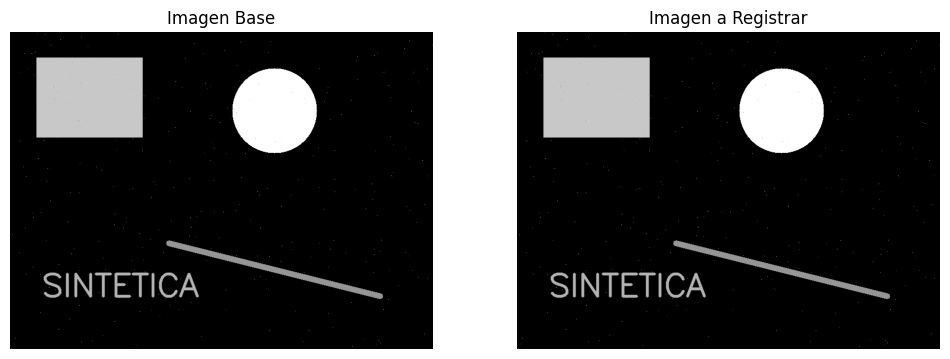

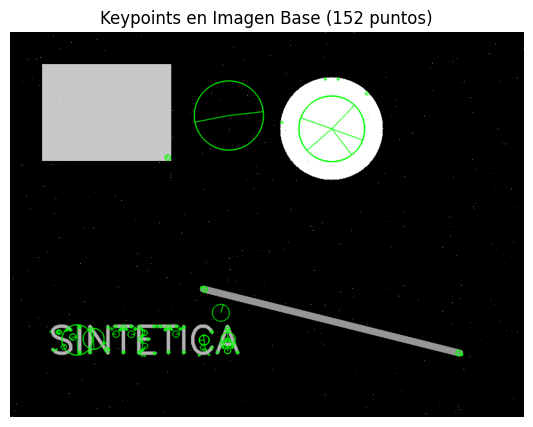

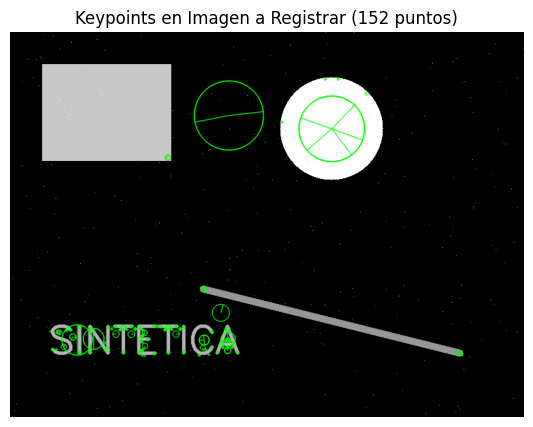

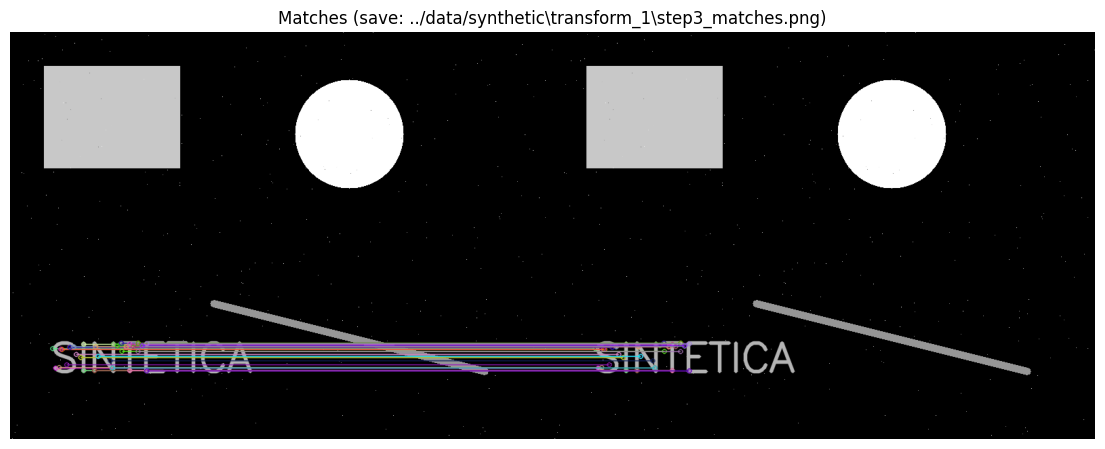

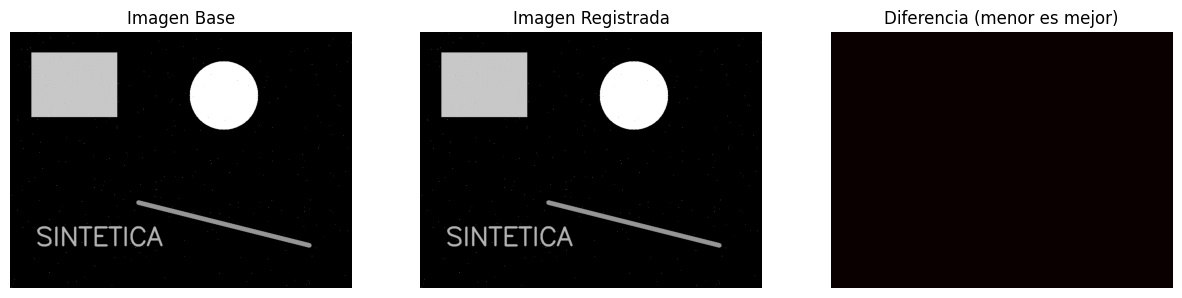

Transformación 1 completada:
  - Keypoints detectados: 152 y 152
  - Matches buenos: 152
  - Error de registro: 0.0000
  - Error vs ground truth: 0.0000

Procesando transformación 2/4


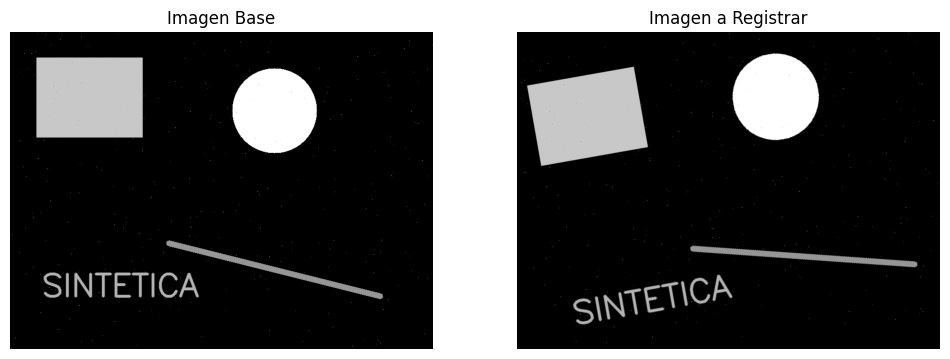

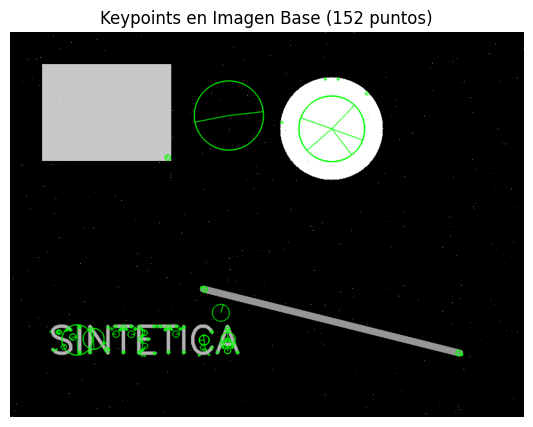

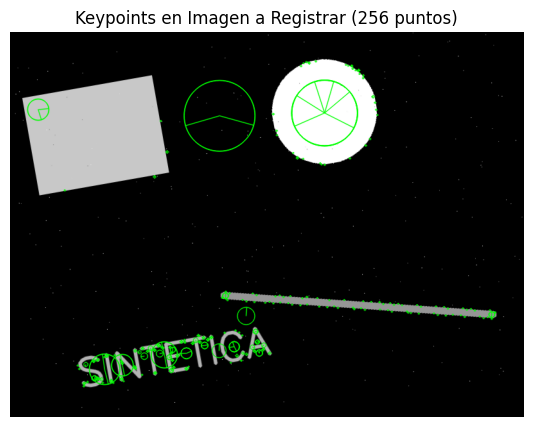

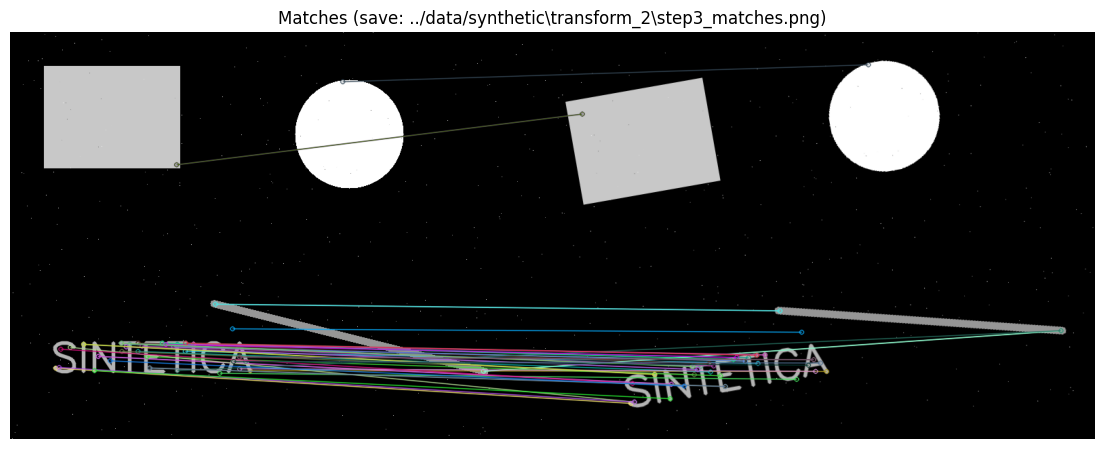

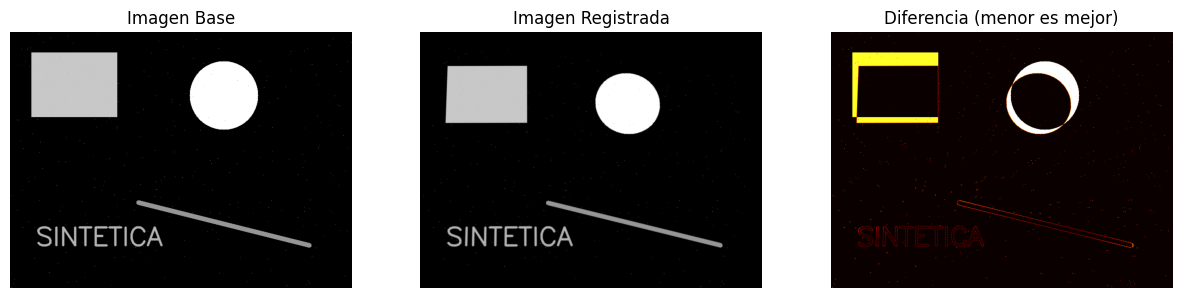

Transformación 2 completada:
  - Keypoints detectados: 152 y 256
  - Matches buenos: 95
  - Error de registro: 8.9238
  - Error vs ground truth: 125.6196

Procesando transformación 3/4


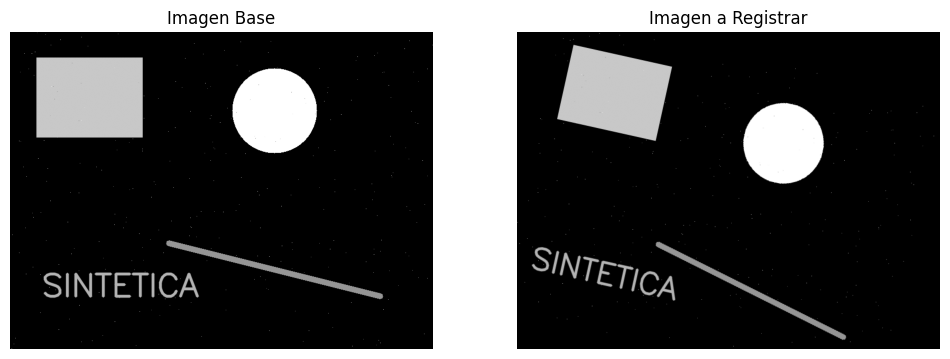

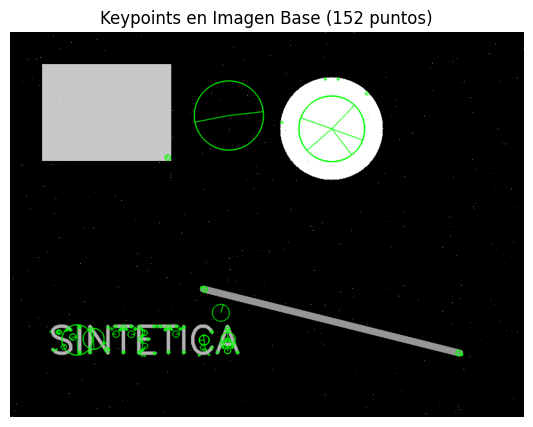

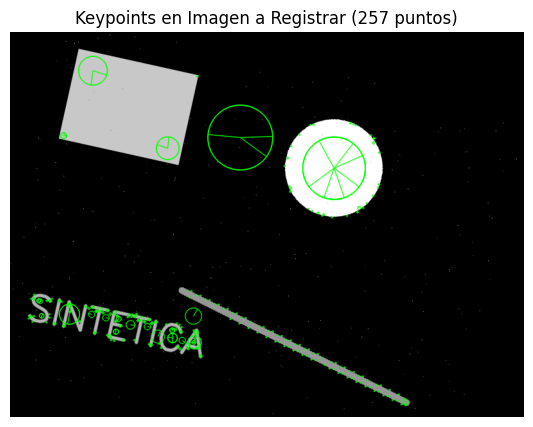

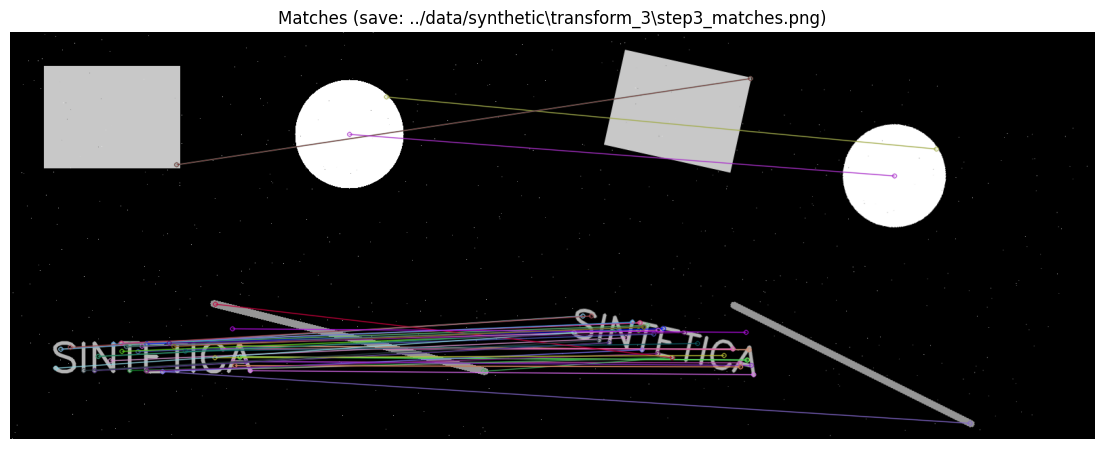

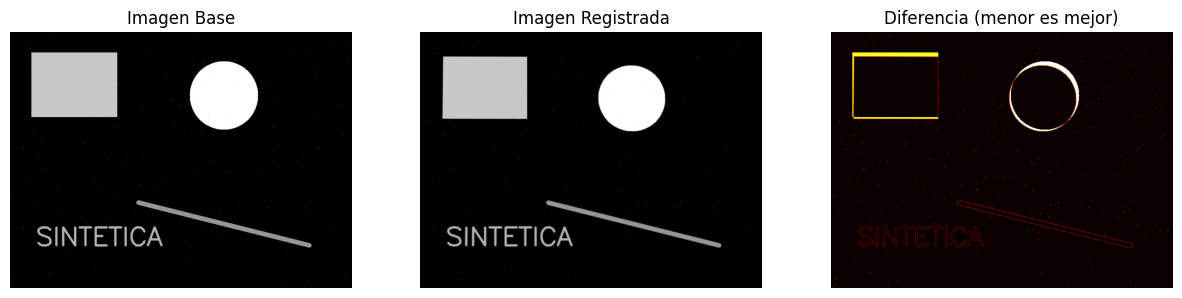

Transformación 3 completada:
  - Keypoints detectados: 152 y 257
  - Matches buenos: 103
  - Error de registro: 3.2991
  - Error vs ground truth: 156.4776

Procesando transformación 4/4


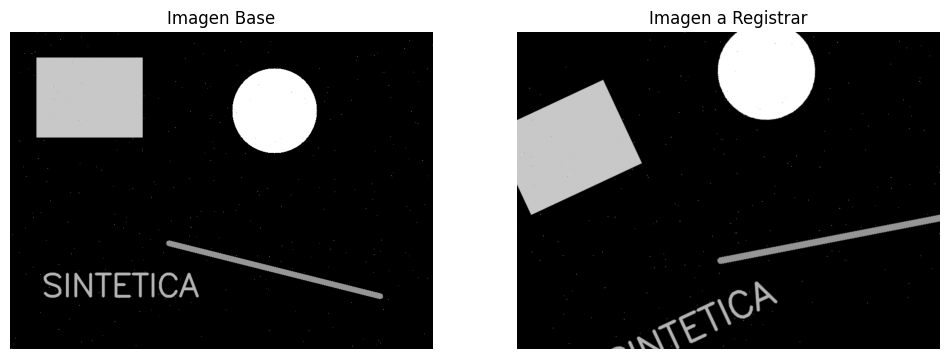

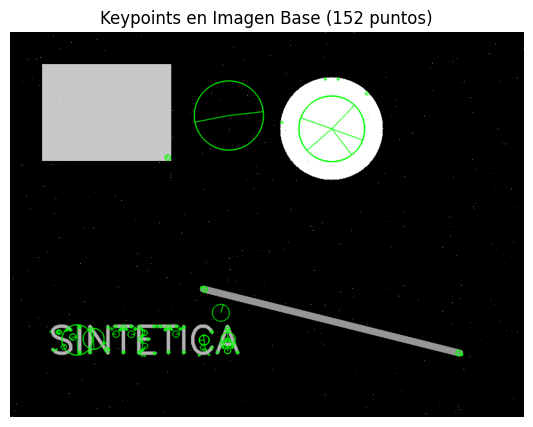

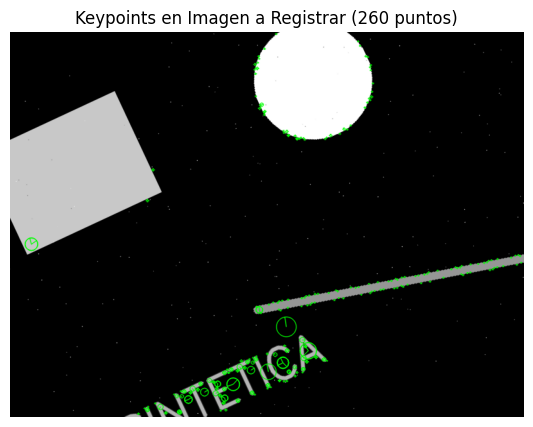

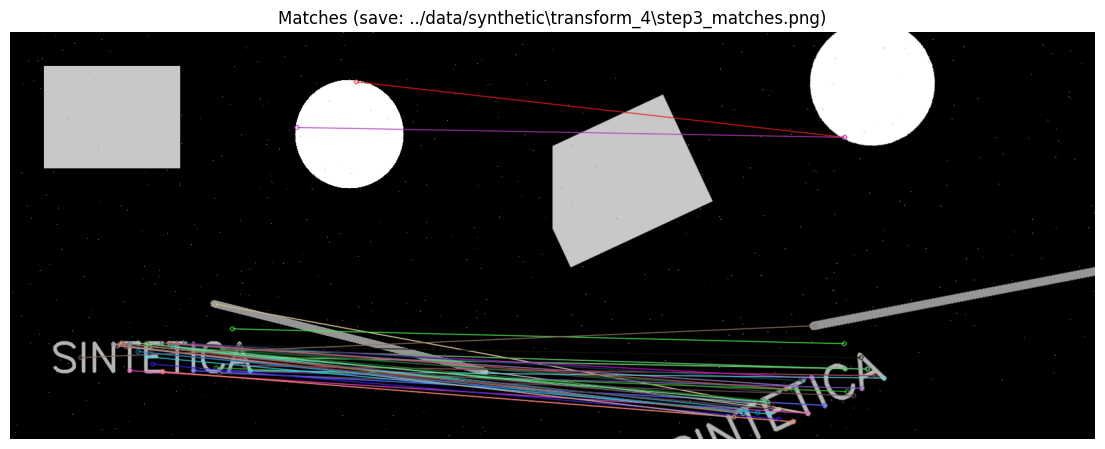

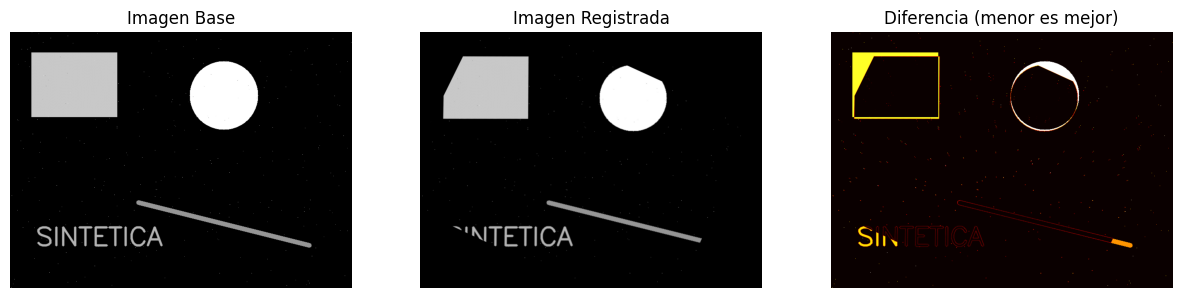

Transformación 4 completada:
  - Keypoints detectados: 152 y 260
  - Matches buenos: 82
  - Error de registro: 4.8452
  - Error vs ground truth: 365.1978


In [14]:
# Procesamiento de imágenes sintéticas
results = []  # Lista para almacenar resultados
ratio_thresh = 0.75  # Umbral para el ratio test de Lowe
ransac_thresh = 3.0  # Umbral para RANSAC

# Generar (o asegurar) la imagen base antes de procesar las transformaciones
# Si durante ediciones previas se eliminó la variable `base`, aquí la recreamos.
base = create_base_image()
# Guardar una copia para inspección y evitar perderla por error
cv2.imwrite(os.path.join(OUTPUT_DIR, 'base_generated.png'), base)

for transform_idx, transform in enumerate(TRANSFORMS):
    print(f"\nProcesando transformación {transform_idx + 1}/{len(TRANSFORMS)}")
    
    # Crear directorio para esta transformación
    transform_dir = os.path.join(OUTPUT_DIR, f'transform_{transform_idx + 1}')
    os.makedirs(transform_dir, exist_ok=True)
    
    # Aplicar transformación usando la función original
    modified, _ = apply_transform(
        base,
        transform['angle'],
        transform['scale'],
        transform['tx'],
        transform['ty']
    )
    
    # Guardar imágenes originales
    cv2.imwrite(os.path.join(transform_dir, 'base.png'), base)
    cv2.imwrite(os.path.join(transform_dir, 'modified.png'), modified)
    
    # Detectar keypoints y descriptores usando la función existente
    kp1, desc1 = detect_and_describe(base)
    kp2, desc2 = detect_and_describe(modified)
    
    # Realizar matching usando la función existente
    good_matches = match_descriptors(desc1, desc2, ratio=ratio_thresh)
    
    # Obtener puntos correspondientes
    if len(good_matches) >= 4:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Calcular homografía con RANSAC
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, ransac_thresh)
        
        if H is not None:
            # Visualizar todo el proceso
            registered = visualize_registration_steps(
                base, modified, kp1, kp2, good_matches, H, transform_dir
            )
            
            # Calcular métricas
            error = calculate_registration_error(base, registered)
            transform_gt = transform['matrix']
            gt_error = calculate_matrix_difference(H, transform_gt)
            
            results.append({
                'transform_id': transform_idx + 1,
                'n_keypoints1': len(kp1),
                'n_keypoints2': len(kp2),
                'n_matches': len(good_matches),
                'registration_error': error,
                'gt_error': gt_error
            })
            
            print(f"Transformación {transform_idx + 1} completada:")
            print(f"  - Keypoints detectados: {len(kp1)} y {len(kp2)}")
            print(f"  - Matches buenos: {len(good_matches)}")
            print(f"  - Error de registro: {error:.4f}")
            print(f"  - Error vs ground truth: {gt_error:.4f}")
        else:
            print(f"No se pudo encontrar una homografía válida para la transformación {transform_idx + 1}")
    else:
        print(f"No hay suficientes matches buenos para la transformación {transform_idx + 1}")

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results)

# Parámetros del Proceso de Registro y su Impacto

Los siguientes parámetros afectan significativamente la calidad del registro de imágenes:

## Detección de Puntos Clave (Keypoints)
- **detector_type**: El tipo de detector (SIFT, ORB, etc.) afecta la robustez y precisión
  - SIFT: Más robusto a cambios de escala y rotación, pero más lento
  - ORB: Más rápido pero menos preciso en cambios significativos

## Emparejamiento (Matching)
- **ratio_threshold**: Controla la selectividad de los matches
  - Valores más bajos (0.6-0.7): Matches más selectivos y precisos, pero menos cantidad
  - Valores más altos (0.8-0.9): Más matches pero potencialmente más falsos positivos

## Transformación Geométrica
- **ransac_threshold**: Tolerancia para considerar un match como inlier en RANSAC
  - Valores más bajos (1-3): Más estricto, mejor precisión pero requiere matches muy buenos
  - Valores más altos (4-10): Más tolerante a ruido pero puede resultar en transformaciones menos precisas

## Impacto de las Transformaciones en la Imagen
Las diferentes transformaciones afectan la dificultad y precisión del registro:

### Transformaciones Geométricas
1. **Traslación**:
   - La más simple de manejar
   - Afecta poco a los descriptores locales
   - Alta tasa de éxito en el registro

2. **Rotación**:
   - Moderadamente compleja
   - SIFT maneja bien rotaciones hasta 360°
   - ORB es efectivo hasta ±30°
   - Puede requerir ratio_threshold más alto (≈0.8)

3. **Escalado**:
   - Mayor complejidad
   - SIFT es robusto hasta factores de 2x
   - Puede requerir ajuste en ransac_threshold
   - Considerar más octavas en SIFT para cambios

# Conclusion

- El pipeline sintético (creación, detección, matching y estimación con RANSAC) demuestra que para rotaciones/traslaciones moderadas y sin degradaciones severas la homografía/afin se recupera con bajo error; SIFT + ratio test + RANSAC es una combinación robusta.